<a href="https://colab.research.google.com/github/Aman-Singh-Akhand/GSOC-2025-Deep-Lens/blob/main/Specific_Test_II_Lens_Finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Specific Test II. Lens Finding**
For this task I have used CNN network with CONV2D and Maxpooling layers. I have used two such blocks folwed by flattening and dense layers. I used Keras hyperband tuning for the optimization of hyperparameters. Validation accuracy of approximately 95% was obtained.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install keras scikit-learn matplotlib keras-tuner
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 593.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00


In [5]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import keras_tuner as kt
import matplotlib.pyplot as plt

# Function to load data from a given directory
def load_data(directory):
    images = []
    labels = []
    #I have modified the original folders. I have made separate folders for train and test
    for label, folder in enumerate(["lenses", "nonlenses"]):
        folder_path = os.path.join(directory, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".npy"):
                img = np.load(os.path.join(folder_path, file_name))
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [6]:
# Loading training and test data from folders 'train' and 'test'
train_images, train_labels = load_data('/content/drive/MyDrive/GSC/lens-finding-test/train')
test_images, test_labels = load_data('/content/drive/MyDrive/GSC/lens-finding-test/test')

# Normalize the data
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images to match Keras input requirements (64x64 with 3 channels)
train_images = train_images.reshape(-1, 64, 64, 3)
test_images = test_images.reshape(-1, 64, 64, 3)




In [18]:
# Split training data for validation during tuning
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
# CNN network for classification
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Set up KerasTuner (Hyperband)
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     hyperband_iterations=1,
                     directory='keras_tuner_dir',
                     project_name='lens_identification')

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Retrieve the best model from tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model to file
best_model.save('best_lens_model.h5')


Trial 30 Complete [00h 07m 48s]
val_accuracy: 0.9534615874290466

Best val_accuracy So Far: 0.9572438597679138
Total elapsed time: 01h 20m 07s


Test Accuracy: 0.9839, Test Loss: 0.0581
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
AUC: 0.9336


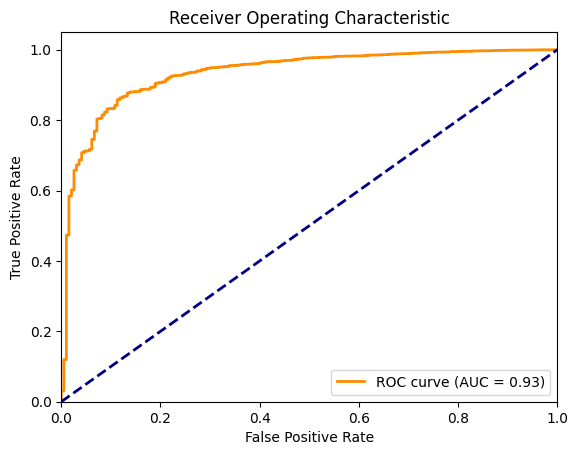

In [ ]:
# The best model on the test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

y_pred_prob = best_model.predict(test_images)

# ROC curve and AUC score
fpr, tpr, _ = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot of ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [3]:
%%shell
jupyter nbconvert --to html /content/Specific_Test_II_Lens_Finding.ipynb

[NbConvertApp] Converting notebook /content/Specific_Test_II_Lens_Finding.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 446907 bytes to /content/Specific_Test_II_Lens_Finding.html


# **Specific Test V. Physics-Guided ML**

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [35]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels)


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)


In [26]:
# Check class distribution in y_test
unique_classes, counts = np.unique(y_test, return_counts=True)
print("Class distribution in y_test:", dict(zip(unique_classes, counts)))



Class distribution in y_test: {np.float64(0.0): np.int64(6082), np.float64(1.0): np.int64(3041)}


In [36]:
import tensorflow.keras.backend as K
import tensorflow as tf

def physics_loss(y_true, y_pred):
    # For multi-label classification, using binary cross-entropy
    ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Physics regularization: encourage spatial smoothness or symmetry (simplified)
    # Assume ideal symmetry in lensing (placeholder for real gravitational physics term)
    physics_reg = K.mean(K.square(y_pred - K.reverse(y_pred, axes=[-1])))

    # Combine cross-entropy loss with the physics-based regularization
    total_loss = ce_loss + 0.01 * physics_reg  # lambda = 0.01

    return total_loss


In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model architecture
def build_pinn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='sigmoid')(x)  # Sigmoid for multi-label classification

    model = Model(inputs, x)
    return model




In [42]:
# Build the model
model = build_pinn_model(input_shape=(64, 64, 3))

# Compile the model for multi-label classification
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6)
]


In [43]:
history = model.fit(
    X_train, y_train,  # Training data and labels
    epochs=15,         # Number of epochs
    batch_size=32,     # Batch size
    validation_data=(X_val, y_val),  # Validation data
    callbacks=callbacks  # Apply callbacks
)


Epoch 1/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 206s 269ms/step - accuracy: 0.9350 - loss: 0.3457 - val_accuracy: 0.9431 - val_loss: 0.2049 - learning_rate: 1.0000e-04
Epoch 2/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 204s 268ms/step - accuracy: 0.9440 - loss: 0.1859 - val_accuracy: 0.9429 - val_loss: 0.1390 - learning_rate: 1.0000e-04
Epoch 3/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 200s 263ms/step - accuracy: 0.9478 - loss: 0.1344 - val_accuracy: 0.9423 - val_loss: 0.1348 - learning_rate: 1.0000e-04
Epoch 4/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 202s 266ms/step - accuracy: 0.9468 - loss: 0.1354 - val_accuracy: 0.9443 - val_loss: 0.1314 - learning_rate: 1.0000e-04
Epoch 5/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 201s 264ms/step - accuracy: 0.9454 - loss: 0.1342 - val_accuracy: 0.9461 - val_loss: 0.1315 - learning_rate: 1.0000e-04
Epoch 6/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 203s 266ms/step - accuracy: 0.9481 - loss: 0.1324 - val_accuracy: 0.9446 - val_loss: 0.1302 - learning_rate: 1.0000e-04
Epoch 7/15
761/761 ━━━━━━━━━━━━━━━━━━━━ 

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
AUC Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


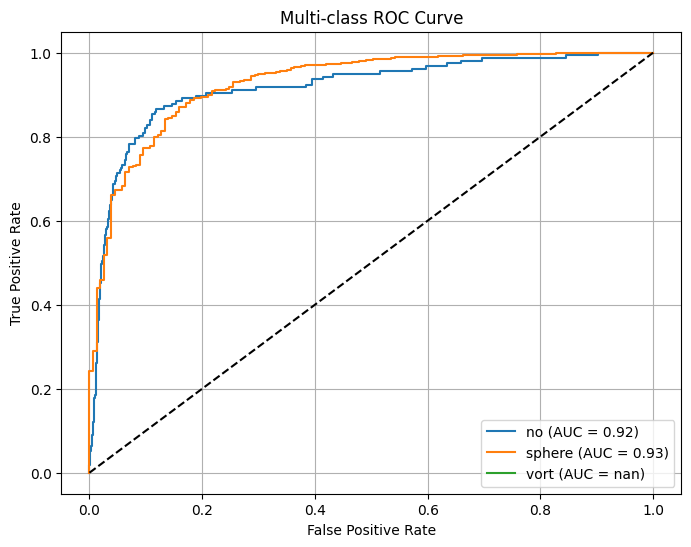

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predictions
y_probs = model.predict(X_test)
y_true = y_test

# Compute AUC
auc_score = roc_auc_score(y_true, y_probs, multi_class='ovr')
print(f"AUC Score: {auc_score:.4f}")

# ROC Curve (one-vs-rest for each class)
fpr = {}
tpr = {}
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])

# Plot ROC Curves
plt.figure(figsize=(8,6))
for i, label in enumerate(['no', 'sphere', 'vort']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc_score(y_true[:, i], y_probs[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
model.save('pinn_model.h5')


In [46]:
model.save('pinn_model.keras')

